# Установка библиотек, скачивание данных

In [ ]:
# Работал с Колаба, поэтому скачиваю сет напрямую с Гита

In [ ]:
!git clone https://github.com/karolpiczak/ESC-50.git

fatal: destination path 'ESC-50' already exists and is not an empty directory.


In [ ]:
import librosa
import librosa.display
import pandas as pd
import numpy as np
import os
import IPython.display as ipd
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

In [ ]:
audio_PATH = 'ESC-50/audio/' # Путь до дорожек

In [ ]:
esc_50 = pd.read_csv('/content/ESC-50/meta/esc50.csv') # Считываю сет

In [ ]:
# Сделаем для удобства словарь перевода таргета к категории:
t2c = esc_50.groupby('target').first()[['category']].to_dict()['category']

In [ ]:
# sr один и тот же для всех файлов, поэтому считаем с любого
_, sr = librosa.load(audio_PATH+esc_50['filename'].iloc[-1])

# Визуализация

In [ ]:
# Соберём по примеру из каждой категории и построим waveplot для каждой:
examples = esc_50.groupby('target').first()[['filename', 'category']]

Как видно из графиков ниже, не смоотря на то, что многие сигналы похожие waveplot'ы, у них могут сильно отличаться percussive и harmonic части, поэтому признаки для модели на табличных данных будем строить на основе всех трёх сигналов: обычном, percussive и harmonic.

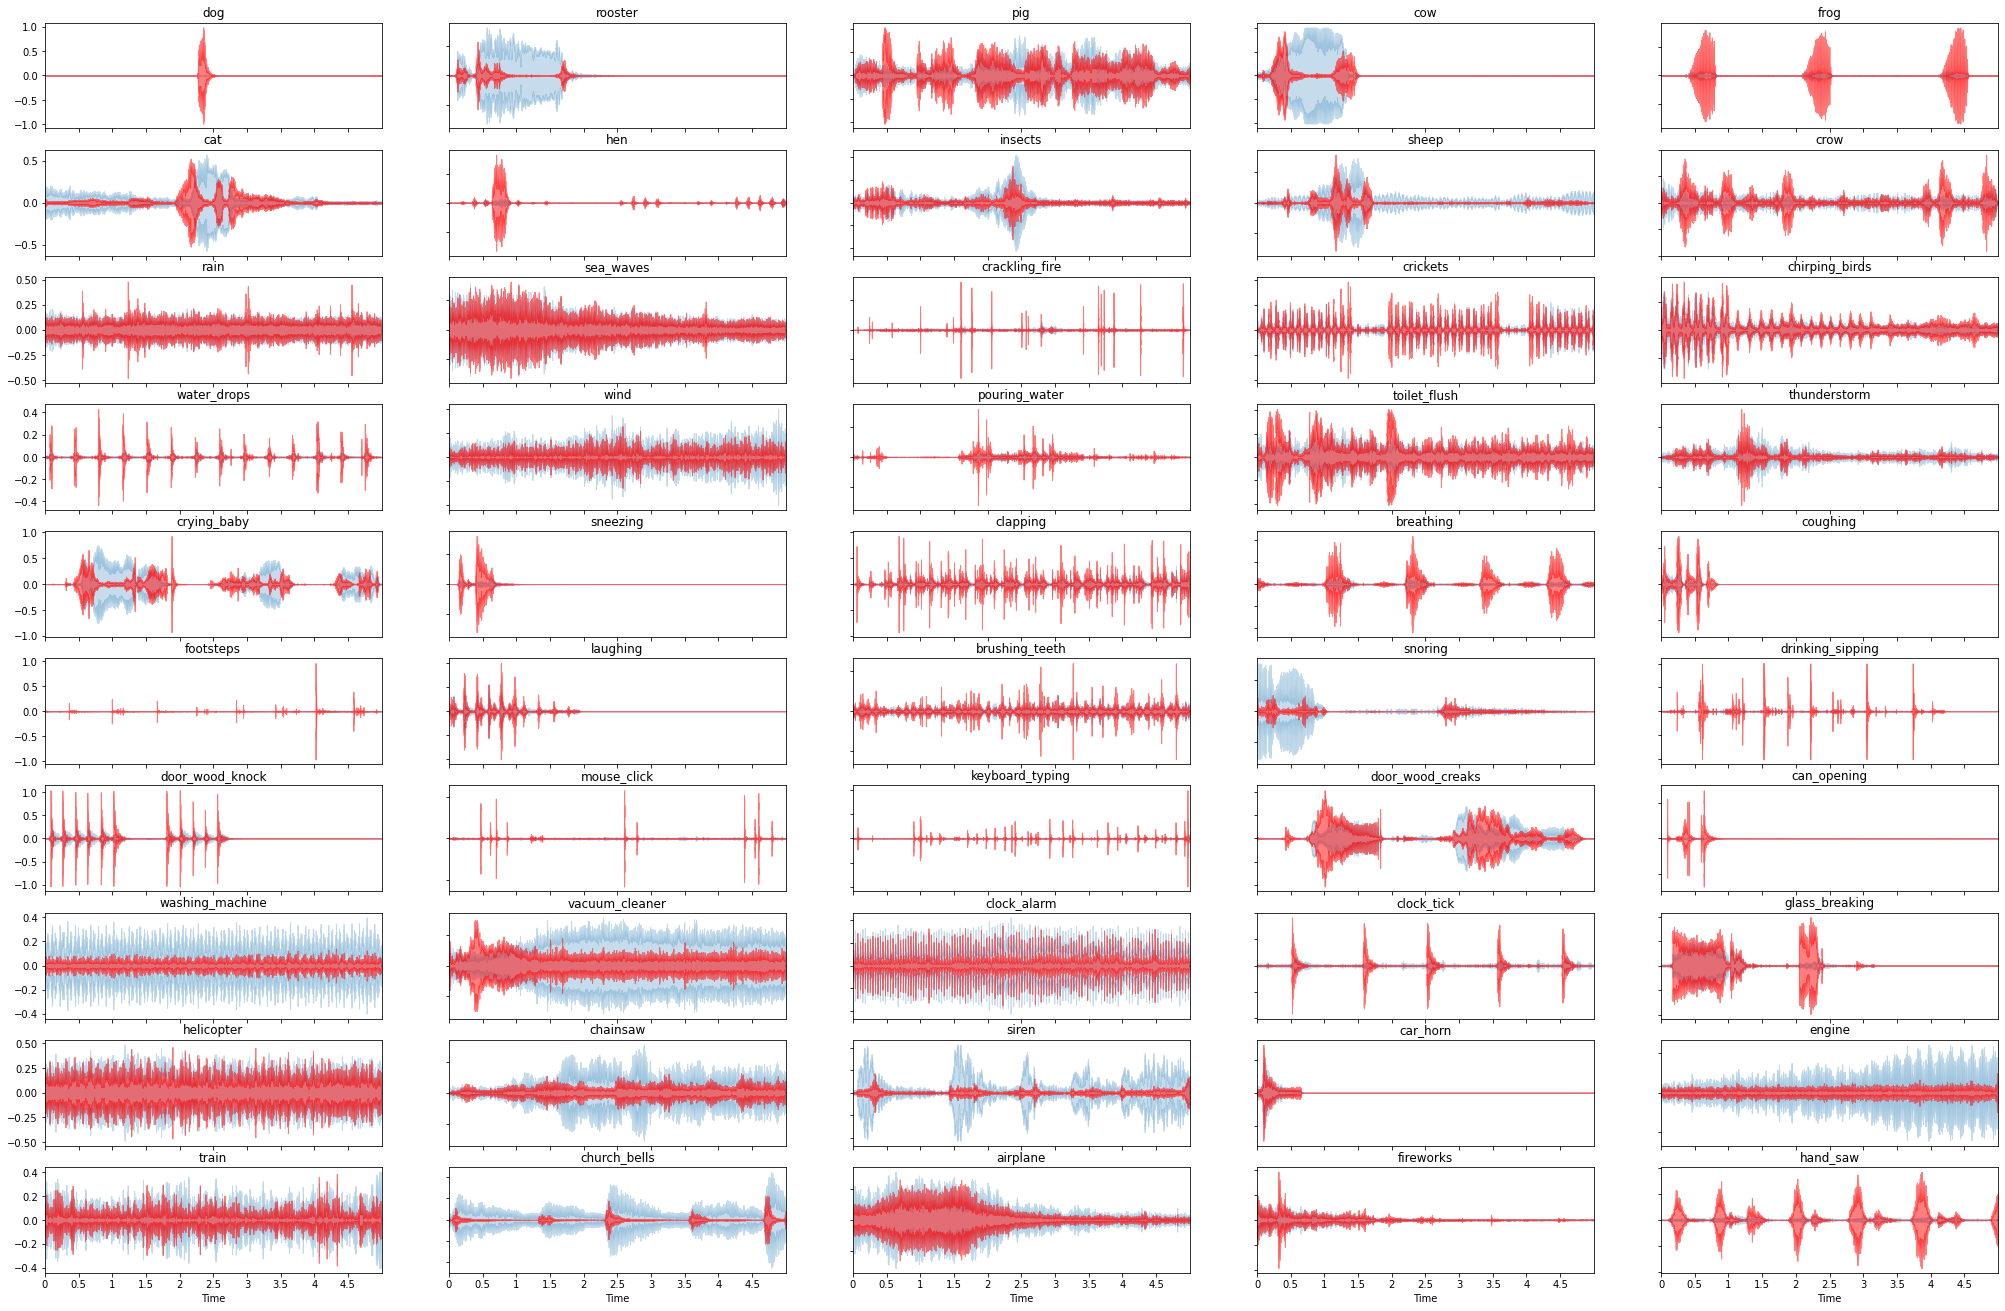

In [ ]:
# Строил графики для harmonic и percussive сигналов,
# чтобы понять, какой превалирует
fig, ax = plt.subplots(nrows=10, ncols=5, sharex=True)
fig.set_size_inches(35, 23)
j = 0
for i in range(len(examples)):
  if i%5==0 and i!=0:
    j += 1
  row = examples.iloc[i]
  y, sr = librosa.load(audio_PATH+row['filename'], duration=5)
  y_harm, y_perc = librosa.effects.hpss(y)
  librosa.display.waveplot(y_harm, sr=sr, alpha=0.25, ax=ax[j, i%5])
  librosa.display.waveplot(y_perc, sr=sr, color='r', alpha=0.5, ax=ax[j, i%5])
  ax[j, i%5].set(title=row['category'])
  ax[j, i%5].label_outer()

# Генерация признаков на табличных данных

In [ ]:
features = esc_50[['filename', 'fold', 'target']]

In [ ]:
# Считываем сигнал
features['loaded'] = (features['filename'].
                      apply(lambda x: librosa.load(audio_PATH + x)[0]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
# Используем разложение сигнала на гармонический и перкурсивный
features['hpss'] =  features['loaded'].apply(lambda x: librosa.effects.hpss(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
features['harmonic'], features['percussive'] = features['hpss'].str

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
# Уже считали с этой колонки что нам нужно, поэтому удаляем
features = features.drop('hpss', axis = 1)

In [ ]:
cols_to_aggregate = ['loaded', 'harmonic', 'percussive']

In [ ]:
from scipy.stats import skew, kurtosis

In [ ]:
def agg_func(df, col_name):
  '''
  df: датафрейм, для которого насчитываем аггрегаты
  col_name: колонка, на основе которой насчитываем признаки
  Функция аггреггирует среднее от col_name, стандартное отклонение,
  ассиметрию и эксцесс
  '''
  df[col_name+'_mean'] = df[col_name].apply(lambda x: np.mean(x))
  df[col_name+'_std'] = df[col_name].apply(lambda x: np.std(x))
  df[col_name+'_skew'] = df[col_name].apply(lambda x: skew(x))
  df[col_name+'_kurtosis'] = df[col_name].apply(lambda x: kurtosis(x))

In [ ]:
# Подсчитаем аггрегирующие функции для сигналов,
# а именно среднее, стандартное отклонение, ассиметрию и эксцесс
for col in cols_to_aggregate:
  agg_func(features, col)

In [ ]:
# Делаем то же самое для zero crossing rate
for col in cols_to_aggregate:
  features[col+'_zcr'] = features[col].apply(lambda x: librosa.feature.
                                        zero_crossing_rate(x)[0])
  agg_func(features, col+'_zcr')
  features = features.drop(col+'_zcr', axis=1)

In [ ]:
# rmse - root mean square energy
for col in cols_to_aggregate:
  features[col+'_rmse'] = (features[col].
                           apply(lambda x: librosa.feature.rms(x)[0]))
  agg_func(features, col+'_rmse')
  features = features.drop(col+'_rmse', axis=1)

In [ ]:
# Вычисление bpm - beats per minute
features['tempo'] = (features.loaded.
                     apply(lambda x: librosa.beat.tempo(librosa.onset.
                                                        onset_strength(y=x))[0]))

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=216
  n_fft, y.shape[-1]


In [ ]:
# Выделим классы для хромаграммы (функция делит дорожку на 12 классов)
pitch_classess = ['C', 'C♯', 'D', 'D♯', 'E' , 'F',
                  'F♯', 'G', 'G♯', 'A', 'A♯', 'B']

In [ ]:
# Насчитываю признаки на основе хромаграммы
for col in cols_to_aggregate:
  features[col+'_chroma_stft'] = features[col].apply(lambda x:
                                                librosa.feature.chroma_stft(x))
  for i, pclass in enumerate(pitch_classess):
    features[col + '_' + pclass] = features[col+'_chroma_stft'].str[i]
    agg_func(features, col + '_' + pclass)
    features = features.drop(col + '_' + pclass, axis=1)
  features = features.drop(col+'_chroma_stft', axis=1)

/usr/local/lib/python3.7/dist-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


In [ ]:
# Признаки на основе спектральноого центроида
for col in cols_to_aggregate:
  features[col+'_spec_cent'] = features.loaded.apply(lambda x: librosa.feature.
                                              spectral_centroid(x)[0])
  agg_func(features, col+'_spec_cent')
  features = features.drop(col+'_spec_cent', axis=1)

In [ ]:
for col in cols_to_aggregate:
  features[col + '_bandwidth'] = features[col].apply(lambda x: librosa.feature.
                                                     spectral_bandwidth(x)[0])
  agg_func(features, col + '_bandwidth')
  features = features.drop(col + '_bandwidth', axis=1)

In [ ]:
roll_percents = [0.15, 0.5, 0.85]
for col in cols_to_aggregate:
  for roll in  roll_percents:
    features[col + f'_rolloff_{roll}'] = (features[col].
                              apply(lambda x: librosa.feature.
                                    spectral_rolloff(y=x, roll_percent=roll)[0]))
    agg_func(features, col + f'_rolloff_{roll}')
    features = features.drop(col + f'_rolloff_{roll}', axis=1)

# Подбор параметров для случайного леса

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneGroupOut

In [ ]:
param_grid = { 
    'n_estimators': [1000],
    'max_features': ['sqrt', 'log2'],
    'criterion' :['gini', 'entropy'],
    'bootstrap' : [True, False]
}

In [ ]:
logo = LeaveOneGroupOut()

In [ ]:
groups = features['fold']

In [ ]:
forest = RandomForestClassifier(random_state = 42)

In [ ]:
cv_features = features[features.columns[6:]]
cv_labels = features['target']

In [ ]:
'''CV_rfc = GridSearchCV(estimator = forest,
                      param_grid = param_grid,
                      scoring ='accuracy',
                      cv = logo.split(cv_features, cv_labels, groups))'''

In [ ]:
#CV_rfc.fit(cv_features, cv_labels)

GridSearchCV(cv=<generator object BaseCrossValidator.split at 0x7fb5407ac3d0>,
             estimator=RandomForestClassifier(random_state=42),
             param_grid={'bootstrap': [True, False],
                         'criterion': ['gini', 'entropy'],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [1000]},
             scoring='accuracy')

In [ ]:
#print(CV_rfc.best_params_, CV_rfc.best_score_)

{'bootstrap': False, 'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 1000} 0.47800000000000004


# Случайный лес

In [ ]:
train = features[features.columns[6:]][features.fold != 5]
test = features[features.columns[6:]][features.fold == 5]
train_labels = features['target'][features.fold != 5]
test_labels = features['target'][features.fold == 5]

In [ ]:
best_forest = RandomForestClassifier(n_estimators = 1000, bootstrap = False,
                                     criterion = 'gini', max_features = 'sqrt',
                                     random_state = 42)

In [ ]:
best_forest.fit(train, train_labels)

RandomForestClassifier(bootstrap=False, max_features='sqrt', n_estimators=1000,
                       random_state=42)

In [ ]:
pred_test = best_forest.predict(test)

In [ ]:
accuracy_score(test_labels, pred_test)

0.45

# Логистическая регрессия

Посмотрим, какой результат покажет регрессия в сравнении с лесом

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
train = features[features.columns[6:]][features.fold != 5]
test = features[features.columns[6:]][features.fold == 5]
train_labels = features['target'][features.fold != 5]
test_labels = features['target'][features.fold == 5]

In [ ]:
normalized_df=(df-df.mean())/df.std()

In [ ]:
norm_train = (train - train.mean())/train.std()
norm_test = (test - test.mean())/test.std()

In [ ]:
logreg = LogisticRegression(penalty = 'l2', max_iter = 1000)

In [ ]:
logreg.fit(norm_train, train_labels)

LogisticRegression(max_iter=1000)

In [ ]:
pred_test = logreg.predict(norm_test)
accuracy_score(test_labels, pred_test)

0.3875

# CatBoost

Используем CatBosst для сравнения

In [ ]:
!pip install catboost

     |████████████████████████████████| 76.1 MB 102 kB/s 


In [ ]:
from catboost import CatBoostClassifier

In [ ]:
train = features[features.columns[6:]][features.fold != 5]
test = features[features.columns[6:]][features.fold == 5]
train_labels = features['target'][features.fold != 5]
test_labels = features['target'][features.fold == 5]

In [ ]:
model = CatBoostClassifier(task_type="GPU",
                           devices='0:1')
model.fit(train, train_labels)

Learning rate set to 0.071437


0:	learn: 3.8280066	total: 102ms	remaining: 1m 41s
1:	learn: 3.7535529	total: 220ms	remaining: 1m 49s
2:	learn: 3.6832739	total: 339ms	remaining: 1m 52s
3:	learn: 3.6100977	total: 436ms	remaining: 1m 48s
4:	learn: 3.5291574	total: 533ms	remaining: 1m 46s
5:	learn: 3.4591785	total: 636ms	remaining: 1m 45s
6:	learn: 3.3966180	total: 719ms	remaining: 1m 42s
7:	learn: 3.3366223	total: 807ms	remaining: 1m 40s
8:	learn: 3.2849060	total: 890ms	remaining: 1m 38s
9:	learn: 3.2276843	total: 980ms	remaining: 1m 37s
10:	learn: 3.1756445	total: 1.06s	remaining: 1m 35s
11:	learn: 3.1186572	total: 1.15s	remaining: 1m 34s
12:	learn: 3.0682208	total: 1.23s	remaining: 1m 33s
13:	learn: 3.0240726	total: 1.32s	remaining: 1m 32s
14:	learn: 2.9760297	total: 1.4s	remaining: 1m 32s
15:	learn: 2.9297095	total: 1.48s	remaining: 1m 31s
16:	learn: 2.8871802	total: 1.56s	remaining: 1m 30s
17:	learn: 2.8461658	total: 1.64s	remaining: 1m 29s
18:	learn: 2.8099338	total: 1.71s	remaining: 1m 28s
19:	learn: 2.7752539	to

In [ ]:
preds = model.predict(test)

In [ ]:
sklearn.metrics.accuracy_score(test_labels, preds)

0.485

В результате модель, показавшая наилучший показатель accuracy, оказалась CatBoost с точностью 0.485. К сожалению, получить результат на уровне >0.8 не получилось для табличных данных.

Взглянем на уровень важности признаков

Как и предполагалось, разделение сигнала на percussive и harmonic, помогло получить важные признаки для модели. Также сильное влияние оказала частота спада скоэффициентом 0.15 и чуть менее сильное с коэффициентом 0.85.

In [ ]:
feature_importance = pd.DataFrame([features.columns[6:],
                                   model.get_feature_importance()]).T
feature_importance.columns = ['feature', 'importance']
feature_importance.index = feature_importance['feature']
feature_importance = feature_importance.drop('feature', axis = 1)
feature_importance = feature_importance.sort_values('importance',
                                                    ascending = False)
feature_importance.head(25)

,importance
feature,
percussive_kurtosis,3.677084
percussive_rmse_std,3.254996
harmonic_rmse_std,2.405939
loaded_rolloff_0.15_std,2.151969
loaded_kurtosis,2.107127
percussive_std,1.659385
percussive_rolloff_0.15_std,1.583247
percussive_rolloff_0.85_mean,1.527349
harmonic_kurtosis,1.526043


# Теперь попробуем использовать спектограммы для классификации.

In [ ]:
def get_melspec_db(file_path):
  y, sr = librosa.load(file_path)
  S = librosa.feature.melspectrogram(y=y, sr=sr)
  S_db = librosa.power_to_db(S, ref=np.max)
  return S_db

In [ ]:
def spec_to_image(spec, eps=1e-6):
  mean = spec.mean()
  std = spec.std()
  spec_norm = (spec - mean) / (std + eps)
  spec_min, spec_max = spec_norm.min(), spec_norm.max()
  spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
  spec_scaled = spec_scaled.astype(np.uint8)
  return spec_scaled

[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

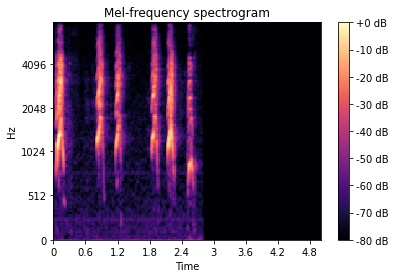

In [ ]:
fig, ax = plt.subplots()
S_dB = get_melspec_db(audio_PATH + esc_50.iloc[-1]['filename'])
img = librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sr,
                               fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

In [ ]:
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [ ]:
class ESC50(Dataset):
  def __init__(self, df, img_paths, targets):
      self.df = df
      self.data = []
      self.labels = []
      for i in tqdm(range(len(df))):
        row = df.iloc[i]
        self.data.append(spec_to_image(get_melspec_db
                                       (audio_PATH +
                                        row[img_paths]))[np.newaxis,...])
        self.labels.append(row[targets])
  def __len__(self):
    return len(self.data)
  def __getitem__(self, idx):
    return self.data[idx], self.labels[idx]

In [ ]:
train = esc_50[esc_50.fold!=5]
test = esc_50[esc_50.fold==5]

In [ ]:
train_data = ESC50(train, 'filename', 'target')
test_data = ESC50(test, 'filename', 'target')

100%|██████████| 400/400 [02:19<00:00,  2.87it/s]


In [ ]:
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16, shuffle=True)

In [ ]:
from torchvision.models import resnet34
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
if torch.cuda.is_available():
  device=torch.device('cuda:0')
else:
  device=torch.device('cpu')

# Функция обучения

Напишем функцию для обучения моделей

In [ ]:
def train_model(model, loss_func, train_loader, test_loader, epochs, optimizer,
                train_losses, test_losses):
  for epoch in tqdm(range(epochs)):
    model.train()
    batch_losses=[]
    for i, data in enumerate(train_loader):
      x, y = data
      optimizer.zero_grad()
      x = x.to(device, dtype=torch.float32)
      y = y.to(device, dtype=torch.long)
      y_hat = model(x)
      loss = loss_func(y_hat, y)
      loss.backward()
      batch_losses.append(loss.item())
      optimizer.step()
    train_losses.append(batch_losses)
    print(f'Epoch - {epoch} Train-Loss : {np.mean(train_losses[-1])}')
    model.eval()
    batch_losses=[]
    trace_y = []
    trace_yhat = []
    for i, data in enumerate(test_loader):
      x, y = data
      x = x.to(device, dtype=torch.float32)
      y = y.to(device, dtype=torch.long)
      y_hat = model(x)
      loss = loss_func(y_hat, y)
      trace_y.append(y.cpu().detach().numpy())
      trace_yhat.append(y_hat.cpu().detach().numpy())      
      batch_losses.append(loss.item())
    test_losses.append(batch_losses)
    trace_y = np.concatenate(trace_y)
    trace_yhat = np.concatenate(trace_yhat)
    accuracy = np.mean(trace_yhat.argmax(axis=1)==trace_y)
    print(f'Epoch - {epoch} Valid-Loss : {np.mean(test_losses[-1])} Valid-Accuracy : {accuracy}')

# Своя свёрточная модель

Напишу свою модель и посмотрю, какой результат она покажет

In [ ]:
class my_model(nn.Module):
  def __init__(self, input_shape, output_shape):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 64, kernel_size = 3, stride=1, padding=1)
    self.bn1 = nn.BatchNorm2d(64)
    self.conv2 = nn.Conv2d(64, 128, kernel_size = 3, stride=1, padding=1)
    self.bn2 = nn.BatchNorm2d(128)
    self.conv3 = nn.Conv2d(128, 256, kernel_size = 3, stride=1, padding=1)
    self.bn3 = nn.BatchNorm2d(256)
    self.dense1 = nn.Linear(256*(((input_shape[1]//2)//2)//2)*
                            (((input_shape[2]//2)//2)//2),512)
    self.dense2 = nn.Linear(512, output_shape)
    self.dropout = nn.Dropout(0.5)
    self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(self.bn1(x))
    x = self.maxpool(x)
    x = self.conv2(x)
    x = F.relu(self.bn2(x))
    x = self.maxpool(x)
    x = self.conv3(x)
    x = F.relu(self.bn3(x))
    x = self.maxpool(x)
    x = self.dropout(x)
    x = x.view(x.size(0),-1)
    x = self.dense1(x)
    x = self.dropout(x)
    x = self.dense2(x)
    return x

In [ ]:
my_model = my_model((1, 128, 216), 50).to(device)
lr = 1e-4
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(my_model.parameters(), lr=lr)
epochs = 30
my_model_train_losses=[]
my_model_test_losses=[]

Точность обычной модели получилась примерно 0.5 

In [ ]:
train_model(my_model, loss_func, train_loader, test_loader, epochs, optimizer,
      my_model_train_losses, my_model_test_losses)

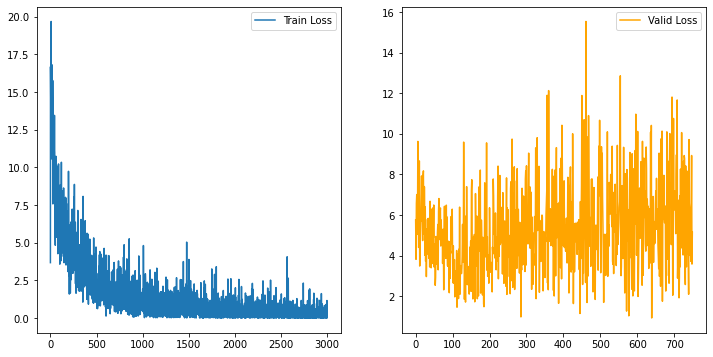

In [ ]:
tl = np.asarray(my_model_train_losses).ravel()
vl = np.asarray(my_model_test_losses).ravel()
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(tl)
plt.legend(['Train Loss'])
plt.subplot(1,2,2)
plt.plot(vl,'orange')
plt.legend(['Valid Loss'])

# ResNet34

Для начала попробуем исппользовать ResNet34

In [ ]:
resnet_model = resnet34(pretrained=True)
resnet_model.fc = nn.Linear(512,50)
resnet_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2),
                               padding=(3, 3), bias=False)
resnet_model = resnet_model.to(device)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

Параметры для модели выбрал стандартные, SGD в качестве оптимизатора, кросс-энтропию как функцию потерь, скорость обучения 0.001

In [ ]:
lr = 1e-3
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet_model.parameters(), lr=lr, momentum=0.9)
epochs = 50
resnet_train_losses=[]
resnet_test_losses=[]

In [ ]:
train_model(resnet_model, loss_func, train_loader, test_loader, epochs, optimizer,
      resnet_train_losses, resnet_test_losses)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch - 0 Train-Loss : 3.346228287220001


  2%|▏         | 1/50 [00:18<14:45, 18.06s/it]

Epoch - 0 Valid-Loss : 2.6505955600738527 Valid-Accuracy : 0.3575
Epoch - 1 Train-Loss : 1.8733017861843109


  4%|▍         | 2/50 [00:35<14:16, 17.84s/it]

Epoch - 1 Valid-Loss : 2.009215612411499 Valid-Accuracy : 0.46
Epoch - 2 Train-Loss : 1.13948351085186


  6%|▌         | 3/50 [00:53<13:54, 17.76s/it]

Epoch - 2 Valid-Loss : 1.518113489151001 Valid-Accuracy : 0.585
Epoch - 3 Train-Loss : 0.747766584455967


  8%|▊         | 4/50 [01:11<13:35, 17.73s/it]

Epoch - 3 Valid-Loss : 1.7648582434654236 Valid-Accuracy : 0.5325
Epoch - 4 Train-Loss : 0.48726555943489075


 10%|█         | 5/50 [01:28<13:16, 17.70s/it]

Epoch - 4 Valid-Loss : 1.2827443194389343 Valid-Accuracy : 0.6225
Epoch - 5 Train-Loss : 0.34707272946834566


 12%|█▏        | 6/50 [01:46<12:57, 17.68s/it]

Epoch - 5 Valid-Loss : 1.2707785308361053 Valid-Accuracy : 0.6675
Epoch - 6 Train-Loss : 0.21900219786912203


 14%|█▍        | 7/50 [02:04<12:39, 17.67s/it]

Epoch - 6 Valid-Loss : 1.1556476986408233 Valid-Accuracy : 0.66
Epoch - 7 Train-Loss : 0.16820650212466717


 16%|█▌        | 8/50 [02:21<12:21, 17.66s/it]

Epoch - 7 Valid-Loss : 1.2013491809368133 Valid-Accuracy : 0.655
Epoch - 8 Train-Loss : 0.1337267492711544


 18%|█▊        | 9/50 [02:39<12:03, 17.65s/it]

Epoch - 8 Valid-Loss : 1.2148334765434265 Valid-Accuracy : 0.6525
Epoch - 9 Train-Loss : 0.09926770824939013


 20%|██        | 10/50 [02:56<11:45, 17.64s/it]

Epoch - 9 Valid-Loss : 1.1362253475189208 Valid-Accuracy : 0.675
Epoch - 10 Train-Loss : 0.09393310592509806


 22%|██▏       | 11/50 [03:14<11:27, 17.64s/it]

Epoch - 10 Valid-Loss : 1.3980985355377198 Valid-Accuracy : 0.6325
Epoch - 11 Train-Loss : 0.06977210208773613


 24%|██▍       | 12/50 [03:32<11:10, 17.64s/it]

Epoch - 11 Valid-Loss : 1.1244579291343688 Valid-Accuracy : 0.69
Epoch - 12 Train-Loss : 0.057531880596652624


 26%|██▌       | 13/50 [03:49<10:52, 17.64s/it]

Epoch - 12 Valid-Loss : 1.1420171689987182 Valid-Accuracy : 0.6975
Epoch - 13 Train-Loss : 0.04912294485606253


 28%|██▊       | 14/50 [04:07<10:35, 17.64s/it]

Epoch - 13 Valid-Loss : 1.1550688469409942 Valid-Accuracy : 0.6925
Epoch - 14 Train-Loss : 0.037957445718348026


 30%|███       | 15/50 [04:25<10:17, 17.64s/it]

Epoch - 14 Valid-Loss : 1.0688372576236724 Valid-Accuracy : 0.695
Epoch - 15 Train-Loss : 0.03451184344943613


 32%|███▏      | 16/50 [04:42<09:59, 17.64s/it]

Epoch - 15 Valid-Loss : 1.0299850106239319 Valid-Accuracy : 0.71
Epoch - 16 Train-Loss : 0.027876901547424494


 34%|███▍      | 17/50 [05:00<09:42, 17.64s/it]

Epoch - 16 Valid-Loss : 1.0766360282897949 Valid-Accuracy : 0.695
Epoch - 17 Train-Loss : 0.028903300552628935


 36%|███▌      | 18/50 [05:18<09:24, 17.65s/it]

Epoch - 17 Valid-Loss : 1.14002521276474 Valid-Accuracy : 0.6975
Epoch - 18 Train-Loss : 0.0219281746679917


 38%|███▊      | 19/50 [05:35<09:07, 17.65s/it]

Epoch - 18 Valid-Loss : 1.115255811214447 Valid-Accuracy : 0.7025
Epoch - 19 Train-Loss : 0.022638112315908076


 40%|████      | 20/50 [05:53<08:49, 17.64s/it]

Epoch - 19 Valid-Loss : 1.1176087814569473 Valid-Accuracy : 0.7125
Epoch - 20 Train-Loss : 0.016936100940220057


 42%|████▏     | 21/50 [06:10<08:31, 17.64s/it]

Epoch - 20 Valid-Loss : 1.0630810087919236 Valid-Accuracy : 0.715
Epoch - 21 Train-Loss : 0.017613269947469236


 44%|████▍     | 22/50 [06:28<08:13, 17.64s/it]

Epoch - 21 Valid-Loss : 1.1126754975318909 Valid-Accuracy : 0.7
Epoch - 22 Train-Loss : 0.02053365089232102


 46%|████▌     | 23/50 [06:46<07:56, 17.64s/it]

Epoch - 22 Valid-Loss : 1.1413662707805634 Valid-Accuracy : 0.69
Epoch - 23 Train-Loss : 0.01480345435673371


 48%|████▊     | 24/50 [07:03<07:38, 17.64s/it]

Epoch - 23 Valid-Loss : 1.121923677921295 Valid-Accuracy : 0.685
Epoch - 24 Train-Loss : 0.014157610724214464


 50%|█████     | 25/50 [07:21<07:21, 17.65s/it]

Epoch - 24 Valid-Loss : 1.1513239538669586 Valid-Accuracy : 0.69
Epoch - 25 Train-Loss : 0.01387988570262678


 52%|█████▏    | 26/50 [07:39<07:03, 17.65s/it]

Epoch - 25 Valid-Loss : 1.0598398697376252 Valid-Accuracy : 0.705
Epoch - 26 Train-Loss : 0.013432228558231145


 54%|█████▍    | 27/50 [07:56<06:45, 17.64s/it]

Epoch - 26 Valid-Loss : 1.1303169798851014 Valid-Accuracy : 0.7075
Epoch - 27 Train-Loss : 0.01507257484132424


 56%|█████▌    | 28/50 [08:14<06:27, 17.63s/it]

Epoch - 27 Valid-Loss : 1.1096672403812409 Valid-Accuracy : 0.7
Epoch - 28 Train-Loss : 0.012542144992621615


 58%|█████▊    | 29/50 [08:32<06:10, 17.64s/it]

Epoch - 28 Valid-Loss : 1.1053688263893127 Valid-Accuracy : 0.705
Epoch - 29 Train-Loss : 0.015535524911247194


 60%|██████    | 30/50 [08:49<05:52, 17.64s/it]

Epoch - 29 Valid-Loss : 1.1587777495384217 Valid-Accuracy : 0.7
Epoch - 30 Train-Loss : 0.020172524036606774


 62%|██████▏   | 31/50 [09:07<05:35, 17.65s/it]

Epoch - 30 Valid-Loss : 1.1278138780593872 Valid-Accuracy : 0.695
Epoch - 31 Train-Loss : 0.015316708345199003


 64%|██████▍   | 32/50 [09:25<05:17, 17.64s/it]

Epoch - 31 Valid-Loss : 1.2562225461006165 Valid-Accuracy : 0.6925
Epoch - 32 Train-Loss : 0.015337092535337432


 66%|██████▌   | 33/50 [09:42<04:59, 17.65s/it]

Epoch - 32 Valid-Loss : 1.1377637994289398 Valid-Accuracy : 0.7075
Epoch - 33 Train-Loss : 0.013139111091149971


 68%|██████▊   | 34/50 [10:00<04:42, 17.65s/it]

Epoch - 33 Valid-Loss : 1.1475411063432694 Valid-Accuracy : 0.7025
Epoch - 34 Train-Loss : 0.008621591188712046


 70%|███████   | 35/50 [10:17<04:24, 17.65s/it]

Epoch - 34 Valid-Loss : 1.083539913892746 Valid-Accuracy : 0.7175
Epoch - 35 Train-Loss : 0.007416441339300945


 72%|███████▏  | 36/50 [10:35<04:07, 17.65s/it]

Epoch - 35 Valid-Loss : 1.0790205404162407 Valid-Accuracy : 0.7275
Epoch - 36 Train-Loss : 0.006124415817903355


 74%|███████▍  | 37/50 [10:53<03:49, 17.65s/it]

Epoch - 36 Valid-Loss : 1.075057566165924 Valid-Accuracy : 0.7075
Epoch - 37 Train-Loss : 0.006112339040846564


 76%|███████▌  | 38/50 [11:10<03:31, 17.65s/it]

Epoch - 37 Valid-Loss : 1.103969669342041 Valid-Accuracy : 0.725
Epoch - 38 Train-Loss : 0.00720913102501072


 78%|███████▊  | 39/50 [11:28<03:14, 17.65s/it]

Epoch - 38 Valid-Loss : 1.09225259244442 Valid-Accuracy : 0.7075
Epoch - 39 Train-Loss : 0.0056560259155230596


 80%|████████  | 40/50 [11:46<02:56, 17.64s/it]

Epoch - 39 Valid-Loss : 1.1009380030632019 Valid-Accuracy : 0.7125
Epoch - 40 Train-Loss : 0.008431995753198862


 82%|████████▏ | 41/50 [12:03<02:38, 17.65s/it]

Epoch - 40 Valid-Loss : 1.0963583719730376 Valid-Accuracy : 0.7175
Epoch - 41 Train-Loss : 0.007092123991460539


 84%|████████▍ | 42/50 [12:21<02:21, 17.65s/it]

Epoch - 41 Valid-Loss : 1.1199560260772705 Valid-Accuracy : 0.7125
Epoch - 42 Train-Loss : 0.008346631259773857


 86%|████████▌ | 43/50 [12:39<02:03, 17.65s/it]

Epoch - 42 Valid-Loss : 1.0744996881484985 Valid-Accuracy : 0.7225
Epoch - 43 Train-Loss : 0.008529117531143129


 88%|████████▊ | 44/50 [12:56<01:45, 17.64s/it]

Epoch - 43 Valid-Loss : 1.140475606918335 Valid-Accuracy : 0.7
Epoch - 44 Train-Loss : 0.005937878619297407


 90%|█████████ | 45/50 [13:14<01:28, 17.64s/it]

Epoch - 44 Valid-Loss : 1.0939480209350585 Valid-Accuracy : 0.7225
Epoch - 45 Train-Loss : 0.005269867558963597


 92%|█████████▏| 46/50 [13:32<01:10, 17.64s/it]

Epoch - 45 Valid-Loss : 1.0805746114253998 Valid-Accuracy : 0.725
Epoch - 46 Train-Loss : 0.005365566522232257


 94%|█████████▍| 47/50 [13:49<00:52, 17.63s/it]

Epoch - 46 Valid-Loss : 1.0508096009492873 Valid-Accuracy : 0.72
Epoch - 47 Train-Loss : 0.006226085157250054


 96%|█████████▌| 48/50 [14:07<00:35, 17.64s/it]

Epoch - 47 Valid-Loss : 1.111207367181778 Valid-Accuracy : 0.7075
Epoch - 48 Train-Loss : 0.005006468599895016


 98%|█████████▊| 49/50 [14:24<00:17, 17.64s/it]

Epoch - 48 Valid-Loss : 1.0598725414276122 Valid-Accuracy : 0.71
Epoch - 49 Train-Loss : 0.004950970976497046


100%|██████████| 50/50 [14:42<00:00, 17.65s/it]

Epoch - 49 Valid-Loss : 1.0577421045303346 Valid-Accuracy : 0.725


ResNet34 показал точность, равную 0.725, что намного лучше, чем показали модели на табличных данных.